# Test Training Face Emotion Dataset 
## Source : https://www.kaggle.com/datasets/mh0386/facial-emotion/data


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPool2D, Dropout, Flatten, Dense, Input
# compile model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam



def load_image(dir='train'):
	'''
	Load images from directory

	:param dir: directory of images
	:return: image generator
	'''
	datagen = ImageDataGenerator(rescale=1./255,
							rotation_range=40,
							shear_range=0.2,
							zoom_range=0.2,
							horizontal_flip=True,
							fill_mode='nearest')  # Normalize images
	
	train_gen = datagen.flow_from_directory(
		dir,
		target_size=(224, 224),
		batch_size=32,
		class_mode='categorical'
	)

	return train_gen


def load_model():
    
	from tensorflow.keras.applications import VGG16
	base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Set the entire model's layers to non-trainable
	for layer in base_model.layers:
		layer.trainable = False

	return base_model


def build_model(base_model, output_dim=2):
	'''
	Build a model on top of the base model
	
	:param base_model: base model
	:param output_dim: number of output classes
	:return: model
	'''
	model = base_model.output
	model = MaxPool2D(pool_size=(7, 7))(model)
	model = Flatten()(model)
	model = Dense(128, activation='relu')(model)
	model = Dropout(0.5)(model)
	model = Dense(output_dim, activation='softmax')(model)

	return model



	

In [3]:
train_gen = load_image()

Found 112 images belonging to 8 classes.


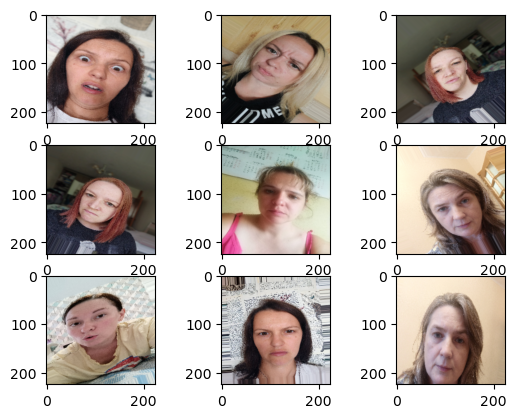

In [4]:
# show one image
import matplotlib.pyplot as plt

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][0]
	plt.imshow(image)

In [5]:
# load model
base_model = load_model()
Yhat = build_model(base_model, train_gen.num_classes)


# compile modelb
model = Model(inputs=base_model.input, outputs=Yhat)

# Example: Unfreeze the top 3 layers
for layer in model.layers[-20:]:
    layer.trainable = True






2024-02-06 17:38:09.620154: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-06 17:38:09.620463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-06 17:38:09.620492: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-06 17:38:09.621361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-06 17:38:09.622165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:

model.compile(
	optimizer=Adam(learning_rate=0.00005),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

# train model
model.fit(
	train_gen,
	epochs=20,
	steps_per_epoch=train_gen.samples // train_gen.batch_size,

)

Epoch 1/20


2024-02-06 17:38:47.037185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 12s 2s/step - loss: 3.3082 - accuracy: 0.1125
Epoch 2/20
3/3 [==============================] - 9s 2s/step - loss: 2.6044 - accuracy: 0.0750
Epoch 3/20
3/3 [==============================] - 11s 3s/step - loss: 2.5447 - accuracy: 0.1146
Epoch 4/20
3/3 [==============================] - 9s 3s/step - loss: 2.3400 - accuracy: 0.1625
Epoch 5/20
3/3 [==============================] - 9s 2s/step - loss: 2.4142 - accuracy: 0.1125
Epoch 6/20
3/3 [==============================] - 8s 2s/step - loss: 2.4995 - accuracy: 0.1375
Epoch 7/20
3/3 [==============================] - 8s 2s/step - loss: 2.4254 - accuracy: 0.1250
Epoch 8/20
3/3 [==============================] - 10s 3s/step - loss: 2.3725 - accuracy: 0.1250
Epoch 9/20
3/3 [==============================] - 9s 2s/step - loss: 2.4766 - accuracy: 0.1500
Epoch 10/20
3/3 [==============================] - 11s 4s/step - loss: 2.3071 - accuracy: 0.1750
Epoch 11/20
3/3 [==============================] - 11s 3

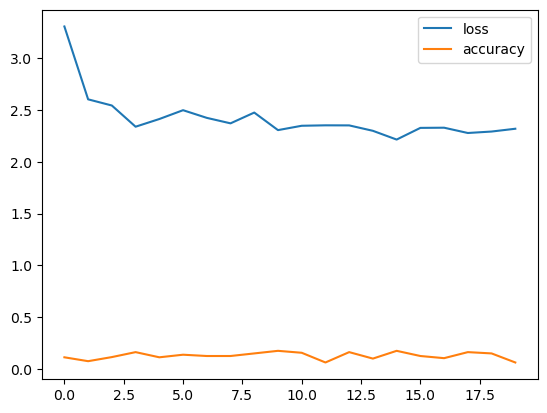

Found 40 images belonging to 8 classes.
2/2 [==============================] - 5s 1s/step - loss: 2.0970 - accuracy: 0.1250
Test Loss: 2.096970558166504
Test Accuracy: 0.125


In [7]:
# plot loss and accuracy
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

# evaluate model
test_generator = load_image('test')

loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")




In [8]:
# save model
model.save('model.h5')


/Users/vickieduong/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
